# Homework Assignment: 06-Python-APIs - WeatherPy
@Author: Jeffery Brown (daddyjab)  
@Date: 01/01/19

-------

# Analysis of Variation by Latitude of Weather: <br>Temperature, Humidity, Cloudiness, and Wind Speed

## Summary:
* Temperature shows a clear pattern of variation by latitude, with temperatures increasing near the equator (0 degree latitude) and decreasing near the poles
* Neither Humidity nor Cloudiness show a pattern of variation by latitude
* Wind Speed is relatively uniform across most latitudes, but with relatively higher wind speeds occurring near the poles

## Data Gathered and Plotted
* Data from over 500 cities were randomly selected from across the full set of global latitude and longitude areas for which Citipy has data populated.
* Weather data for these cities was gathered from the OpenWeatherMap API and various weather patterns populated by latitude.
* Cities for which no weather data was available or which had invalid data (e.g., Humidity > 100%) were dropped from the data.
* Per-city weather results were generated using scatter plots, and median weather results were generated using bar charts
* For each plot, marker color was varied based upon the value of the weather characteristic being plotted.
* For the scatter plots, a moving average trend line (window size = 20 samples) was added to highlight and pattern of variation of the mean by latitude
* For the bar plots, each bar represents the median weather characteristic for a particular range of latitude.  Error bars based upon the standard erroro of the mean have also been provided.


## Results
### Temperature
|Temperature|Median Temperature|
|-----------|------------------|
|<img src="Results/temp_by_latitude_scatter.png" /> | <img src="Results/temp_by_latitude_median.png" /> |

* Both the moving average trend line scatter plot of per-city temperature by latitude and the bar chart of median temperature by latitude show a clear relationship between temperature and latitude.
* For a specific band of latitude there is less variation in southern latitudes (0 to -90 deg) vs. northern latitudes (0 to +90 deg). A next step that might be useful could be to examine variation temperature in a specific latitude band based upon longitude or other factors, including level of population, industrialization, etc.

### Humidity
|Humidity|Median Humidity|
|--------|---------------|
|<img src="Results/humidity_by_latitude_scatter.png" /> | <img src="Results/humidity_by_latitude_median.png" /> |

* The plots of both humidity and median humidity both show significant variation in humidity levels across most latitudes, with neither moving average nor median humidity showing a significant pattern by latitude.

### Cloudiness
|Cloudiness|Median Cloudiness|
|----------|-----------------|
|<img src="Results/cloud_by_latitude_scatter.png" /> | <img src="Results/cloud_by_latitude_median.png" /> |

* The plots of both cloudiness and median cloudiness across most latitudes suggest no significant trend w.r.t. latitude.
* Cloudiness near the equator (~0 to 20 degress latitude) appears to be relatively low vs other areas, but this may be just coincidence, with cloudiness there being different on other days/times of day.  A follow-up study could check the variation in cloudiness for that region over time.

### Wind Speed
|Wind Speed|Median Wind Speed|
|----------|-----------------|
|<img src="Results/wind_speed_by_latitude_scatter.png" /> | <img src="Results/wind_speed_by_latitude_median.png" /> |

* The plots of both wind speed and median wind speed across most latitudes shows moving average and median wind speeds fairly level.  
* An exception to this is relatively higher wind speeds at the poles vs. the equatorial region.

# Implementation

## Dependencies and Function Definitions

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

import random as random
import gmaps
from pprint import pprint
import pycountry
from IPython.display import (Image, HTML)
import logging
import math
from scipy import stats


# Keys
from api_config import (key_openweathermap, key_gmaps)

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
ofile_city_weather_data = "Results/city_weather_data.csv"

# Logging File
ofile_progress_log = "Results/progress.log"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List
* 500 or more cities selected at random latitudes and longitudes from the entire range of lat./long. values could still result in a less than representative sample of cities in the world.
* To mitigate this, a uniform grid of latitude and longitude points will be defined.  Then a set of random latitude and longitude points will be selected about each of these points, ensuring that our sample of cities will encompass all lat/long areas.
* Citypy will then be used to identify cities near each of the sample points that have a population of over 500.
* Granularity of the uniform lat/long grid will be adjusted so that approx 500 cities are selected in the random sampling.

## Approach
1. Set the granularity (grid_gran) of the uniform latitude / longitude grid; start with grid_gran=10 degrees (which yields 648 grid areas)
    * Number of latitude grid sections = (180 - [-180]) / grid_gran = 360 / grid_gran
    * Number of longitude grid sections = (90 - [-90]) / grid_gran = 180 / grid_gran
    * Number of lat/long grid areas = n_grid_areas = (360 * 180) / (grid_gran^2)

1. Generate a grid of latitude and longitude numbers for the entire world
1. For each lat/long grid point, generate a small set of random sample of lat/long points from within the grid_gran by grid_gran area about the lat/long grid point.
1. For each random sample lat/long point, use citipy to determine the nearest city.
1. NOT IMPLEMENTED: If the citipy nearest city is within the grid_gran by grid_gran area surrounding the sample lat/long point, then include it in our list of cities.  Otherwise exclude that city from list of cities -- it is not representative of the target lat/long point.
1. Manually check the tally of cities in the city list to see if we have about 500 unique cities.  If not, adjust the granularity (grid_gran) as appropriate.  (If we have way too many grid areas and resultant cities, then may need to just perform a random sample of the city list.)

In [2]:
# Limit latitude to allowable values
def limit_lat(alat):
    return max(min(alat,90),-90)

# Limit longitude to allowable values
def limit_long(along):
    return max(min(along,180),-180)

# Generate a random lat/long point within each grid area
def random_latlong(gp,gg):
    # Generate a random lat/long point 
    #  that is within (gg) by (gg) area around grid lat/long point (gp)
    r_lat = limit_lat(gp[0] + random.uniform(-gg/2.0, +gg/2.0))
    r_long = limit_long(gp[1] + random.uniform(-gg/2.0, +gg/2.0))
    
    return (r_lat, r_long)

# Check if a specified lat/long point is within a grid area of a reference lat/long point
def check_latlong(gp,rp,gg):
    # If the specified grid point (gp) is within
    #  (gg) by (gg) area around the reference lat/long point (rp),
    #  then return True, otherwise False
    if (abs(gp[0] - rp[0]) <= gg/2.0) and (abs(gp[1] - rp[1]) <= gg/2.0):
        return True
    else:
        return False
    
# Check if a specified value is in the range >=0% and <=100%
def valid_0to100(a):
    if a>=0.0 and a<= 100.0:
        return True
    else:
        return False

# Function to prep a weather icon url for display with HTML formating
def prep_image(ipath):
    return '<img src="' + ipath + '" />'

# Function to generate an array containing the
#  moving average of the list provided in the argument
def moving_average(values, window_size):
    # Create a "window" based upon the window size with value 1/window_size
    window = np.ones(int(window_size))/float(window_size)
    
    # Calculate the average of the window moving across the elements of "values"
    #  using the convolve function to multiply and add
    return np.convolve( values, window, 'same')


In [3]:
# Grid granularity (degrees of latitude or longitude)
grid_gran = 7

# Establish the grid as a list of lat/long tuples
grid_latlong = [( limit_lat(round(lat,2)), limit_long(round(long,2)) )
                for lat in np.arange(-90.0,90.0+grid_gran,grid_gran)
                for long in np.arange(-180.0, 180.0+grid_gran, grid_gran)
               ]
n_grid_areas = len(grid_latlong)
n_grid_areas

1431

In [4]:
# Initialize the list of cities
cities_df = pd.DataFrame(columns = ['City Name',
                                    'Country Name', 'Country Official Name', 'Country Code', 
                                    'Target Lat', 'Target Long', 'Grid Lat', 'Grid Long'])

# Loop through all grid points
for gp in grid_latlong:
    # For each grid point, select a random lat/long from
    #  within the (grid_gran) x (grid_gran) area around the grid point
    rp = random_latlong(gp, grid_gran)
    
    # print(f"Grid Point: {gp}, Random Point: {rp}")
    
    # Get the city nearest to the random point using citipy
    n_city = citipy.nearest_city(rp[0], rp[1])
    
    # Get the name of the city
    city_name = n_city.city_name.title()

    # Get the 2-letter country code for the country in which this city is located
    country_code = n_city.country_code.upper()
    
    # Get the name of the country that this nearest city is in
    #   country.alpha_2 = 2-letter abbreviation of the country (i.e., country code) [key for this look-up]
    #   country.name = Common name of the country
    #   country.official_name = Official name of the country
    
    # Some country codes are not populated in the country module
    try:
        country = pycountry.countries.get(alpha_2 = country_code )
        country_name = country.name
    except:
        country_name = country_code
    
    # Some countries do not have official_name populated
    try:
        country_official_name = country.official_name
    except:
        country_official_name = country_name
    
    # At this point, the plan was to compare the actual lat/long of the city that was found
    #  to the lat/long of the grid point (gp) and to only include this city in the cities list
    #  if this city is with the (grid_gran) x (grid_gran) area around the grid point.
    # But... citipy doesn't return the actual lat/long of the nearest city (even though it has this info),
    #  and would need to refactor the citipy code to provide a method of access this info.
    # Instead, will just skip this check for now...
    
    # Check to make sure this city is not already in the list of cities
    # Note: It's ok to have dup city name as long as country is different
    if cities_df['City Name'].loc[  (cities_df['City Name'] == city_name)
                                  & (cities_df['Country Code'] == country_code) ].count() == 0:
    
        # Ok, add the city to the list of cities
        cities_df = cities_df.append({
                                    'City Name':city_name,
                                    'Country Code':country_code,
                                    'Country Name':country_name,
                                    'Country Official Name':country_official_name,
                                    'Target Lat':float(rp[0]),
                                    'Target Long':float(rp[1]),
                                    'Grid Lat':float(gp[0]),
                                    'Grid Long':float(gp[1]),
                                    }, ignore_index=True)
    

In [5]:
cities_df.dtypes

City Name                 object
Country Name              object
Country Official Name     object
Country Code              object
Target Lat               float64
Target Long              float64
Grid Lat                 float64
Grid Long                float64
dtype: object

# Get City Weather Information


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
# Prepare items needed for OpenWeatherMap API calls
owm_base_url = "http://api.openweathermap.org/data/2.5/weather?"
owm_key = "appid=" + key_openweathermap
owm_units = "units=imperial"

# Other info: Base URL for weather icon
owm_iconbase_url = "http://openweathermap.org/img/w/"
owm_icon_suffix = ".png"

# Prepare the logfile
logging.basicConfig(filename=ofile_progress_log, filemode='w', level=logging.INFO,
                    format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

for ci in cities_df.index:
    # Initialize a list to hold progress information
    #  for display on console (using 'print') and log file (using 'logging.info')
    progress_info = [ f"Getting Weather Info for City #{ci}: {cities_df.loc[ci, 'City Name']} ({cities_df.loc[ci, 'Country Name']})" ]
    progress_info.append(f"> Target Lat: {cities_df.loc[ci, 'Target Lat']}, Target Long: {cities_df.loc[ci, 'Target Long']}]")
    
    # Assemble the query url for this
    owm_city = cities_df.loc[ci, 'City Name']
    owm_country_code = cities_df.loc[ci, 'Country Code']
    owm_full_url = owm_base_url + owm_key + "&" + owm_units + "&q=" + owm_city + "," + owm_country_code

    # Submit the GET request to the OpenWeatherMap API and process the JSON response
    w_response = requests.get(owm_full_url)
    w_json = w_response.json()
    
    # If the weather is not available for this city, stop processing
    if w_json['cod'] != 200:
        progress_info.append(f"> No weather data available for this city (code: {w_json['cod']}, message: {w_json['message']})\n")
        
        for p in progress_info:
            print(p)
            logging.info(p)
            
        continue

    # City weather info
    # Temperature (Fahrenheit)
    try:
        c_temp = float(w_json['main']['temp'])
    except:
        c_temp = None

    # Humidity (%)
    try:
        c_humid = float(w_json['main']['humidity'])
    except:
        c_humid = None

    # Cloudiness (%)
    try:
        c_cloud = float(w_json['clouds']['all'])
    except:
        c_cloud = None

    # Wind Speed (mph)
    try:
        c_wind_speed = float(w_json['wind']['speed'])
    except:
        c_wind_speed = None
    
    # Wind Direction (degrees)
    try:
        c_wind_dir = float(w_json['wind']['deg'])
    except:
        c_wind_dir = None

    # Actual Latitude and Longitude
    try:
        c_act_lat = float(w_json['coord']['lat'])
        c_act_long = float(w_json['coord']['lon'])
    except:
        c_act_lat = None
        c_act_long = None
    
    # Weather Description
    try:
        c_desc = w_json['weather'][0]['description']
    except:
        c_desc = None

    # Weather Icon URL
    try:
        c_icon_url = owm_iconbase_url + w_json['weather'][0]['icon'] + owm_icon_suffix
    except:
        c_icon_url = None
    
    # Just for curiosity sake, check to see if the actual lat/long is
    #  within the target lat/long grid area
    c_in_gridarea = check_latlong( (c_act_lat, c_act_long),
                                   (cities_df.loc[ci, 'Target Lat'], cities_df.loc[ci, 'Target Long']),
                                   grid_gran)
  
    # Print out a nice detailed progress message
    progress_info.append (f"> City: {w_json['name']}, Country: {w_json['sys']['country']}")
    progress_info.append (f"> Temp: {c_temp}, Humidity: {c_humid}, Clouds: {c_cloud}%")
    progress_info.append (f"> Wind: {c_wind_speed} mph at {c_wind_dir} deg")
    progress_info.append (f"> Weather Description: {c_desc}")
    progress_info.append (f"> Weather Icon: {c_icon_url}")
    progress_info.append (f"> Act. Lat: {c_act_lat}, Act. Long: {c_act_long}, In Target Grid Area: {c_in_gridarea}\n")

    for p in progress_info:
        print(p)
        logging.info(p)

    # Populate this data in the cities_df dataframe
    cities_df.loc[ci, 'Actual Lat'] = c_act_lat
    cities_df.loc[ci, 'Actual Long'] = c_act_long
    cities_df.loc[ci, 'In Target Grid Area'] = c_in_gridarea
    cities_df.loc[ci, 'Temp'] = c_temp
    cities_df.loc[ci, 'Humidity'] = c_humid
    cities_df.loc[ci, 'Cloudiness'] = c_cloud
    cities_df.loc[ci, 'Wind Speed'] = c_wind_speed
    cities_df.loc[ci, 'Wind Direction'] = c_wind_dir
    cities_df.loc[ci, 'Weather Description'] = c_desc
    cities_df.loc[ci, 'Weather Icon URL'] = c_icon_url

    #DEBUG
    #if ci>3:
    #    break
        

Getting Weather Info for City #0: Vaini (Tonga)
> Target Lat: -87.40302289348944, Target Long: -178.6226958559754]
> City: Vaini, Country: TO
> Temp: 75.2, Humidity: 88.0, Clouds: 90.0%
> Wind: 12.75 mph at 130.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -21.2, Act. Long: -175.2, In Target Grid Area: False

Getting Weather Info for City #1: Mataura (French Polynesia)
> Target Lat: -89.48358298927279, Target Long: -160.12402467675938]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #2: Rikitea (French Polynesia)
> Target Lat: -90.0, Target Long: -137.39291677746445]
> City: Rikitea, Country: PF
> Temp: 71.38, Humidity: 100.0, Clouds: 92.0%
> Wind: 3.6 mph at 138.001 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10d.png
> Act. Lat: -23.12, Act. Long: -134.97, In Target Grid Area: False

Getting Weather Info for City #3:

Getting Weather Info for City #23: Souillac (Mauritius)
> Target Lat: -61.76458950281652, Target Long: 76.65865943851396]
> City: Souillac, Country: MU
> Temp: 80.6, Humidity: 83.0, Clouds: 40.0%
> Wind: 9.17 mph at 110.0 deg
> Weather Description: shower rain
> Weather Icon: http://openweathermap.org/img/w/09n.png
> Act. Lat: -20.52, Act. Long: 57.52, In Target Grid Area: False

Getting Weather Info for City #24: Castro (Chile)
> Target Lat: -57.12151880616222, Target Long: -107.19131964616633]
> City: Castro, Country: CL
> Temp: 53.6, Humidity: 62.0, Clouds: 75.0%
> Wind: 3.36 mph at None deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: -42.48, Act. Long: -73.76, In Target Grid Area: False

Getting Weather Info for City #25: Chuy (Uruguay)
> Target Lat: -52.80493468470957, Target Long: -30.98146775287328]
> City: Chuy, Country: UY
> Temp: 78.54, Humidity: 91.0, Clouds: 36.0%
> Wind: 13.44 mph at 68.001 deg
> Weather Descript

Getting Weather Info for City #45: Bambous Virieux (Mauritius)
> Target Lat: -40.32851920590555, Target Long: 81.04066434080164]
> City: Bambous Virieux, Country: MU
> Temp: 80.6, Humidity: 83.0, Clouds: 40.0%
> Wind: 9.17 mph at 110.0 deg
> Weather Description: shower rain
> Weather Icon: http://openweathermap.org/img/w/09n.png
> Act. Lat: -20.34, Act. Long: 57.76, In Target Grid Area: False

Getting Weather Info for City #46: Port Lincoln (Australia)
> Target Lat: -41.10580262504465, Target Long: 132.11994362346718]
> City: Port Lincoln, Country: AU
> Temp: 62.25, Humidity: 100.0, Clouds: 0.0%
> Wind: 9.64 mph at 143.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: -34.72, Act. Long: 135.86, In Target Grid Area: False

Getting Weather Info for City #47: Burnie (Australia)
> Target Lat: -41.32828515230851, Target Long: 144.301562826243]
> City: Burnie, Country: AU
> Temp: 60.76, Humidity: 100.0, Clouds: 8.0%
> Wind: 16.69 mph

Getting Weather Info for City #69: Forbes (Australia)
> Target Lat: -32.88108029750935, Target Long: 146.61983244266716]
> City: Forbes, Country: AU
> Temp: 77.28, Humidity: 55.0, Clouds: 36.0%
> Wind: 7.74 mph at 70.001 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: -33.38, Act. Long: 148.01, In Target Grid Area: True

Getting Weather Info for City #70: Port Macquarie (Australia)
> Target Lat: -32.36050431753075, Target Long: 158.20142664233697]
> City: Port Macquarie, Country: AU
> Temp: 71.6, Humidity: 83.0, Clouds: 0.0%
> Wind: 11.41 mph at 40.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: -31.43, Act. Long: 152.91, In Target Grid Area: False

Getting Weather Info for City #71: Ahipara (New Zealand)
> Target Lat: -35.866369034928496, Target Long: 168.8940156129254]
> City: Ahipara, Country: NZ
> Temp: 64.68, Humidity: 100.0, Clouds: 80.0%
> Wind: 6.4 mph at 1

Getting Weather Info for City #92: Dalby (Australia)
> Target Lat: -27.51584345639026, Target Long: 150.84713969472304]
> City: Dalby, Country: AU
> Temp: 68.0, Humidity: 64.0, Clouds: 0.0%
> Wind: 9.17 mph at 80.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: -27.18, Act. Long: 151.26, In Target Grid Area: True

Getting Weather Info for City #93: Hervey Bay (Australia)
> Target Lat: -23.8120376061806, Target Long: 158.39501811572978]
> City: Hervey Bay, Country: AU
> Temp: 69.8, Humidity: 88.0, Clouds: 0.0%
> Wind: 5.82 mph at 190.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: -25.3, Act. Long: 152.85, In Target Grid Area: False

Getting Weather Info for City #94: Noumea (New Caledonia)
> Target Lat: -24.55057356850365, Target Long: 165.63348757984778]
> City: Noumea, Country: NC
> Temp: 71.6, Humidity: 83.0, Clouds: 0.0%
> Wind: 2.24 mph at None deg
> Weather Descrip

Getting Weather Info for City #114: Thohoyandou (South Africa)
> Target Lat: -22.83568172902091, Target Long: 30.480756198793124]
> City: Thohoyandou, Country: ZA
> Temp: 83.08, Humidity: 62.0, Clouds: 88.0%
> Wind: 5.61 mph at 131.001 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: -22.97, Act. Long: 30.46, In Target Grid Area: True

Getting Weather Info for City #115: Beira (Mozambique)
> Target Lat: -19.835614525491458, Target Long: 36.076692047329]
> City: Beira, Country: MZ
> Temp: 86.0, Humidity: 74.0, Clouds: 20.0%
> Wind: 11.88 mph at 102.001 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: -19.84, Act. Long: 34.84, In Target Grid Area: True

Getting Weather Info for City #116: Morondava (Madagascar)
> Target Lat: -20.059760475635656, Target Long: 43.2160717922464]
> City: Morondava, Country: MG
> Temp: 90.42, Humidity: 67.0, Clouds: 8.0%
> Wind: 7.96 mph at 2

Getting Weather Info for City #139: Mozarlandia (Brazil)
> Target Lat: -14.085901979590462, Target Long: -51.944288132801]
> City: Mozarlandia, Country: BR
> Temp: 86.1, Humidity: 70.0, Clouds: 36.0%
> Wind: 4.5 mph at 309.501 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03d.png
> Act. Lat: -14.74, Act. Long: -50.57, In Target Grid Area: True

Getting Weather Info for City #140: Porto Nacional (Brazil)
> Target Lat: -11.028476835147861, Target Long: -47.51451693193165]
> City: Porto Nacional, Country: BR
> Temp: 81.73, Humidity: 98.0, Clouds: 20.0%
> Wind: 4.38 mph at 6.00104 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: -10.7, Act. Long: -48.41, In Target Grid Area: True

Getting Weather Info for City #141: Aquidaba (Brazil)
> Target Lat: -10.31305908272542, Target Long: -36.92081040024146]
> No weather data available for this city (code: 404, message: city not found)

Getting We

Getting Weather Info for City #161: Kirakira (Solomon Islands)
> Target Lat: -10.34690584878886, Target Long: 162.99713609633454]
> City: Kirakira, Country: SB
> Temp: 81.46, Humidity: 100.0, Clouds: 80.0%
> Wind: 13.0 mph at 232.501 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -10.46, Act. Long: 161.92, In Target Grid Area: True

Getting Weather Info for City #162: Sola (Vanuatu)
> Target Lat: -12.612309568331622, Target Long: 167.20379486491933]
> City: Sola, Country: VU
> Temp: 81.69, Humidity: 95.0, Clouds: 64.0%
> Wind: 10.65 mph at 145.001 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -13.88, Act. Long: 167.55, In Target Grid Area: True

Getting Weather Info for City #163: Asau (Tuvalu)
> Target Lat: -13.321664348052016, Target Long: 178.4383718794566]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for

Getting Weather Info for City #207: Harper (Liberia)
> Target Lat: -1.3252645359021802, Target Long: -9.029791633404507]
> City: Harper, Country: LR
> Temp: 79.75, Humidity: 100.0, Clouds: 24.0%
> Wind: 6.29 mph at 193.001 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: 4.38, Act. Long: -7.71, In Target Grid Area: False

Getting Weather Info for City #208: Sassandra (Côte d'Ivoire)
> Target Lat: 2.1564566548212847, Target Long: -5.334496976600125]
> City: Sassandra, Country: CI
> Temp: 81.24, Humidity: 100.0, Clouds: 0.0%
> Wind: 7.96 mph at 178.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 4.95, Act. Long: -6.09, In Target Grid Area: True

Getting Weather Info for City #209: Takoradi (Ghana)
> Target Lat: -0.6666340641084689, Target Long: 0.7808538768390862]
> City: Takoradi, Country: GH
> Temp: 87.18, Humidity: 87.0, Clouds: 0.0%
> Wind: 9.42 mph at 132.001 deg
> W

Getting Weather Info for City #229: Kapaa (United States)
> Target Lat: 10.368982273774439, Target Long: -170.4854645522607]
> City: Kapaa, Country: US
> Temp: 70.61, Humidity: 76.0, Clouds: 90.0%
> Wind: 14.99 mph at 70.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 22.08, Act. Long: -159.32, In Target Grid Area: False

Getting Weather Info for City #230: Makakilo City (United States)
> Target Lat: 5.756317300853299, Target Long: -165.42637708880744]
> City: Makakilo City, Country: US
> Temp: 73.4, Humidity: 84.0, Clouds: 20.0%
> Wind: 3.36 mph at 40.0 deg
> Weather Description: shower rain
> Weather Icon: http://openweathermap.org/img/w/09n.png
> Act. Lat: 21.35, Act. Long: -158.09, In Target Grid Area: False

Getting Weather Info for City #231: Cabo San Lucas (Mexico)
> Target Lat: 8.66841004914957, Target Long: -124.73627198152668]
> City: Cabo San Lucas, Country: MX
> Temp: 56.26, Humidity: 58.0, Clouds: 90.0%
> Win

Getting Weather Info for City #252: Moyale (Ethiopia)
> Target Lat: 4.671400100505917, Target Long: 40.17480407572396]
> City: Moyale, Country: ET
> Temp: 82.63, Humidity: 29.0, Clouds: 0.0%
> Wind: 6.96 mph at 88.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 3.52, Act. Long: 39.05, In Target Grid Area: True

Getting Weather Info for City #253: Hargeysa (Somalia)
> Target Lat: 7.911364065438085, Target Long: 44.205344483415715]
> City: Hargeysa, Country: SO
> Temp: 69.54, Humidity: 43.0, Clouds: 0.0%
> Wind: 6.06 mph at 29.001 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 9.56, Act. Long: 44.06, In Target Grid Area: True

Getting Weather Info for City #254: Eyl (Somalia)
> Target Lat: 7.988806071049657, Target Long: 50.42844949136956]
> City: Eyl, Country: SO
> Temp: 76.56, Humidity: 100.0, Clouds: 88.0%
> Wind: 20.04 mph at 40.001 deg
> Weather Description: light r

Getting Weather Info for City #276: Bathsheba (Barbados)
> Target Lat: 15.810525747239264, Target Long: -56.73327826743138]
> City: Bathsheba, Country: BB
> Temp: 82.4, Humidity: 61.0, Clouds: 20.0%
> Wind: 20.8 mph at 70.0 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: 13.22, Act. Long: -59.52, In Target Grid Area: True

Getting Weather Info for City #277: Ponta Do Sol (Cabo Verde)
> Target Lat: 17.153838149008866, Target Long: -41.17971223609921]
> City: Ponta do Sol, Country: CV
> Temp: 80.6, Humidity: 47.0, Clouds: 0.0%
> Wind: 16.11 mph at 50.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 17.2, Act. Long: -25.09, In Target Grid Area: False

Getting Weather Info for City #278: Pombas (Cabo Verde)
> Target Lat: 18.061929985312887, Target Long: -24.27344847738546]
> City: Pombas, Country: CV
> Temp: 80.6, Humidity: 47.0, Clouds: 0.0%
> Wind: 16.11 mph at 50.0 deg
> W

Getting Weather Info for City #301: Nanakuli (United States)
> Target Lat: 20.575366375900675, Target Long: -159.2187997671606]
> City: Nanakuli, Country: US
> Temp: 73.31, Humidity: 84.0, Clouds: 90.0%
> Wind: 8.05 mph at 90.0 deg
> Weather Description: shower rain
> Weather Icon: http://openweathermap.org/img/w/09n.png
> Act. Lat: 21.39, Act. Long: -158.15, In Target Grid Area: True

Getting Weather Info for City #302: Lompoc (United States)
> Target Lat: 19.85912507984023, Target Long: -130.9420866610635]
> City: Lompoc, Country: US
> Temp: 31.19, Humidity: 84.0, Clouds: 1.0%
> Wind: 8.05 mph at 80.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 34.64, Act. Long: -120.46, In Target Grid Area: False

Getting Weather Info for City #303: Guerrero Negro (Mexico)
> Target Lat: 19.706316227298238, Target Long: -122.53669412484662]
> City: Guerrero Negro, Country: MX
> Temp: 48.16, Humidity: 100.0, Clouds: 20.0%
> Wind: 3.6 mph at 

Getting Weather Info for City #325: Sarankhola (Bangladesh)
> Target Lat: 21.2647627646213, Target Long: 89.7162530576451]
> City: Sarankhola, Country: BD
> Temp: 64.14, Humidity: 71.0, Clouds: 0.0%
> Wind: 8.19 mph at 310.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 22.31, Act. Long: 89.79, In Target Grid Area: True

Getting Weather Info for City #326: Mae Sai (Thailand)
> Target Lat: 21.565859044395676, Target Long: 99.34704324379312]
> City: Mae Sai, Country: TH
> Temp: 66.2, Humidity: 100.0, Clouds: 40.0%
> Wind: 4.7 mph at 40.0 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: 20.43, Act. Long: 99.88, In Target Grid Area: True

Getting Weather Info for City #327: Jinchengjiang (China)
> Target Lat: 24.140827336616606, Target Long: 108.287278094762]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City 

Getting Weather Info for City #349: Nalut (Libya)
> Target Lat: 32.1217778691026, Target Long: 10.597869707004222]
> City: Nalut, Country: LY
> Temp: 56.26, Humidity: 48.0, Clouds: 12.0%
> Wind: 15.79 mph at 336.501 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: 31.86, Act. Long: 10.98, In Target Grid Area: True

Getting Weather Info for City #350: Bani Walid (Libya)
> Target Lat: 31.832971867904853, Target Long: 14.565017198321403]
> City: Bani Walid, Country: LY
> Temp: 48.43, Humidity: 91.0, Clouds: 20.0%
> Wind: 18.25 mph at 333.501 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10d.png
> Act. Lat: 31.76, Act. Long: 14.0, In Target Grid Area: True

Getting Weather Info for City #351: Madinat Sittah Uktubar (Egypt)
> Target Lat: 29.699929703175897, Target Long: 31.367820502007632]
> City: Madinat Sittah Uktubar, Country: EG
> Temp: 62.6, Humidity: 36.0, Clouds: 75.0%
> Wind: 3.36 mph at

Getting Weather Info for City #374: Tahlequah (United States)
> Target Lat: 35.61860848836789, Target Long: -94.92419181701472]
> City: Tahlequah, Country: US
> Temp: 28.99, Humidity: 92.0, Clouds: 90.0%
> Wind: 5.82 mph at 360.0 deg
> Weather Description: mist
> Weather Icon: http://openweathermap.org/img/w/50d.png
> Act. Lat: 35.92, Act. Long: -94.97, In Target Grid Area: True

Getting Weather Info for City #375: Evansville (United States)
> Target Lat: 38.024959494000655, Target Long: -87.87494182952634]
> City: Evansville, Country: US
> Temp: 42.8, Humidity: 85.0, Clouds: 90.0%
> Wind: 6.93 mph at 350.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 37.97, Act. Long: -87.56, In Target Grid Area: True

Getting Weather Info for City #376: Marietta (United States)
> Target Lat: 39.42422691351757, Target Long: -81.30398527449299]
> City: Marietta, Country: US
> Temp: 59.09, Humidity: 99.0, Clouds: 90.0%
> Wind: 2.82 mph at

Getting Weather Info for City #398: Yinchuan (China)
> Target Lat: 38.43577350069917, Target Long: 104.80270248253191]
> City: Yinchuan, Country: CN
> Temp: -2.38, Humidity: 53.0, Clouds: 0.0%
> Wind: 3.71 mph at 356.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 38.48, Act. Long: 106.21, In Target Grid Area: True

Getting Weather Info for City #399: Dongsheng (China)
> Target Lat: 39.37196581500436, Target Long: 111.02428977711143]
> City: Dongsheng, Country: CN
> Temp: 30.84, Humidity: 89.0, Clouds: 64.0%
> Wind: 5.17 mph at 321.501 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 29.72, Act. Long: 112.52, In Target Grid Area: False

Getting Weather Info for City #400: Qinhuangdao (China)
> Target Lat: 39.202294246474416, Target Long: 119.81747690388246]
> City: Qinhuangdao, Country: CN
> Temp: -5.89, Humidity: 57.0, Clouds: 0.0%
> Wind: 2.26 mph at 18.001 deg
> W

Getting Weather Info for City #420: Saint-Pierre (Saint Pierre and Miquelon)
> Target Lat: 42.93334352069942, Target Long: -54.386977726009164]
> City: Saint-Pierre, Country: PM
> Temp: 26.6, Humidity: 73.0, Clouds: 90.0%
> Wind: 10.29 mph at 210.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 46.77, Act. Long: -56.17, In Target Grid Area: False

Getting Weather Info for City #421: Lagoa (Portugal)
> Target Lat: 45.876387598919976, Target Long: -26.019412741893323]
> City: Lagoa, Country: PT
> Temp: 60.8, Humidity: 63.0, Clouds: 0.0%
> Wind: 11.41 mph at 110.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 37.14, Act. Long: -8.45, In Target Grid Area: False

Getting Weather Info for City #422: Muros (Spain)
> Target Lat: 44.143865014756805, Target Long: -13.931590336921872]
> City: Muros, Country: ES
> Temp: 58.91, Humidity: 48.0, Clouds: 0.0%
> Wind: 2.24 mph at 3

Getting Weather Info for City #443: Iwanai (Japan)
> Target Lat: 43.46821929457607, Target Long: 139.5593842741592]
> City: Iwanai, Country: JP
> Temp: 30.7, Humidity: 100.0, Clouds: 76.0%
> Wind: 15.12 mph at 296.001 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 42.97, Act. Long: 140.51, In Target Grid Area: True

Getting Weather Info for City #444: Petropavlovsk-Kamchatskiy (Russian Federation)
> Target Lat: 45.543656367954185, Target Long: 163.79373922668344]
> City: Petropavlovsk-Kamchatskiy, Country: RU
> Temp: -4.01, Humidity: 64.0, Clouds: 8.0%
> Wind: 6.71 mph at 10.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: 53.05, Act. Long: 158.65, In Target Grid Area: False

Getting Weather Info for City #445: Ketchikan (United States)
> Target Lat: 51.74637764228731, Target Long: -134.7181497371807]
> City: Ketchikan, Country: US
> Temp: 45.41, Humidity: 95.0, Cloud

Getting Weather Info for City #464: Kuchl (Austria)
> Target Lat: 47.656327409549704, Target Long: 13.204356849053859]
> City: Kuchl, Country: AT
> Temp: 42.8, Humidity: 88.0, Clouds: 75.0%
> Wind: 17.22 mph at 290.0 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 47.63, Act. Long: 13.15, In Target Grid Area: True

Getting Weather Info for City #465: Giraltovce (Slovakia)
> Target Lat: 48.97939306262852, Target Long: 21.480432179731498]
> City: Giraltovce, Country: SK
> Temp: 33.8, Humidity: 80.0, Clouds: 75.0%
> Wind: 10.29 mph at 210.0 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 49.11, Act. Long: 21.52, In Target Grid Area: True

Getting Weather Info for City #466: Horlesti (Romania)
> Target Lat: 47.10173013853121, Target Long: 27.38714504174481]
> City: Horlesti, Country: RO
> Temp: 39.2, Humidity: 64.0, Clouds: 0.0%
> Wind: 6.93 mph at 180.0 deg
> Weather D

Getting Weather Info for City #488: Fort Nelson (Canada)
> Target Lat: 58.79939113206483, Target Long: -120.48534047364787]
> City: Fort Nelson, Country: CA
> Temp: 24.8, Humidity: 79.0, Clouds: 20.0%
> Wind: 3.36 mph at 140.0 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: 58.81, Act. Long: -122.69, In Target Grid Area: True

Getting Weather Info for City #489: Grand Centre (Canada)
> Target Lat: 59.980682235473544, Target Long: -109.01851099409346]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #490: Flin Flon (Canada)
> Target Lat: 57.46555886465328, Target Long: -102.0747696556636]
> City: Flin Flon, Country: CA
> Temp: -16.61, Humidity: 75.0, Clouds: 75.0%
> Wind: 5.82 mph at 170.0 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 54.77, Act. Long: -101.88, In Target Grid Area: True

Getting Weather Info

Getting Weather Info for City #512: Zalesovo (Russian Federation)
> Target Lat: 54.16009000063666, Target Long: 84.38623416335768]
> City: Zalesovo, Country: RU
> Temp: -4.04, Humidity: 78.0, Clouds: 32.0%
> Wind: 4.94 mph at 204.501 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: 54.0, Act. Long: 84.74, In Target Grid Area: True

Getting Weather Info for City #513: Aginskoye (Russian Federation)
> Target Lat: 54.18816806946023, Target Long: 94.66502681085221]
> City: Aginskoye, Country: RU
> Temp: -21.37, Humidity: 29.0, Clouds: 0.0%
> Wind: 4.61 mph at 293.501 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 51.11, Act. Long: 114.54, In Target Grid Area: False

Getting Weather Info for City #514: Bratsk (Russian Federation)
> Target Lat: 56.92508625218974, Target Long: 101.91340521759953]
> City: Bratsk, Country: RU
> Temp: -11.21, Humidity: 76.0, Clouds: 0.0%
> Win

Getting Weather Info for City #534: Iqaluit (Canada)
> Target Lat: 67.00633190457667, Target Long: -76.0434935287393]
> City: Iqaluit, Country: CA
> Temp: -7.61, Humidity: 69.0, Clouds: 75.0%
> Wind: 3.36 mph at 90.0 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 63.75, Act. Long: -68.52, In Target Grid Area: False

Getting Weather Info for City #535: Pangnirtung (Canada)
> Target Lat: 66.63282186353226, Target Long: -66.56827089289989]
> City: Pangnirtung, Country: CA
> Temp: -7.61, Humidity: 57.0, Clouds: 20.0%
> Wind: 4.7 mph at None deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: 66.15, Act. Long: -65.72, In Target Grid Area: True

Getting Weather Info for City #536: Sisimiut (Greenland)
> Target Lat: 64.4112970440396, Target Long: -58.25396241016683]
> City: Sisimiut, Country: GL
> Temp: 1.41, Humidity: 100.0, Clouds: 32.0%
> Wind: 1.25 mph at 23.001 deg
> Weathe

Getting Weather Info for City #556: Baykit (Russian Federation)
> Target Lat: 62.38211215872605, Target Long: 97.25501186302363]
> City: Baykit, Country: RU
> Temp: -15.43, Humidity: 66.0, Clouds: 64.0%
> Wind: 5.28 mph at 192.001 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 61.68, Act. Long: 96.39, In Target Grid Area: True

Getting Weather Info for City #557: Yerbogachen (Russian Federation)
> Target Lat: 64.16928696870869, Target Long: 105.70950884786488]
> City: Yerbogachen, Country: RU
> Temp: -11.42, Humidity: 74.0, Clouds: 44.0%
> Wind: 5.61 mph at 222.001 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: 61.28, Act. Long: 108.01, In Target Grid Area: True

Getting Weather Info for City #558: Suntar (Russian Federation)
> Target Lat: 60.732171803355584, Target Long: 117.01342777654216]
> City: Suntar, Country: RU
> Temp: -0.44, Humidity: 66.0, Clouds: 44.

Getting Weather Info for City #579: Kautokeino (Norway)
> Target Lat: 68.47925977813614, Target Long: 23.39558984393611]
> City: Kautokeino, Country: NO
> Temp: 17.88, Humidity: 86.0, Clouds: 48.0%
> Wind: 8.63 mph at 4.00104 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03d.png
> Act. Lat: 69.01, Act. Long: 23.04, In Target Grid Area: True

Getting Weather Info for City #580: Mehamn (Norway)
> Target Lat: 71.4089087029565, Target Long: 28.071270359667587]
> City: Mehamn, Country: NO
> Temp: 24.36, Humidity: 86.0, Clouds: 44.0%
> Wind: 14.56 mph at 349.001 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03d.png
> Act. Lat: 71.03, Act. Long: 27.85, In Target Grid Area: True

Getting Weather Info for City #581: Skalistyy (Russian Federation)
> Target Lat: 69.66402836560161, Target Long: 33.508865018925235]
> No weather data available for this city (code: 404, message: city not found)

Getting Weathe

Getting Weather Info for City #602: Berlevag (Norway)
> Target Lat: 80.31344754742514, Target Long: 31.796907479806805]
> City: Berlevag, Country: NO
> Temp: 23.0, Humidity: 92.0, Clouds: 75.0%
> Wind: 23.04 mph at 10.0 deg
> Weather Description: light shower snow
> Weather Icon: http://openweathermap.org/img/w/13d.png
> Act. Lat: 70.86, Act. Long: 29.09, In Target Grid Area: False

Getting Weather Info for City #603: Tumannyy (Russian Federation)
> Target Lat: 81.34129236641675, Target Long: 39.65348799956192]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #604: Dikson (Russian Federation)
> Target Lat: 79.3139586249839, Target Long: 72.45527680106828]
> City: Dikson, Country: RU
> Temp: 15.9, Humidity: 100.0, Clouds: 76.0%
> Wind: 33.8 mph at 261.501 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 73.51, Act. Long: 80.55, In Target Grid Area: False

Getting Weat

## Clean the Data

In [7]:
# Drop any cities for which no weather data is available,
#  using "Temp" as the check
# DEBUG - don't it this inplace: cities_df.dropna(how='any', subset=['Temp'])
cities_df.dropna(how='any', subset=['Temp'], inplace = True)

In [8]:
# Remove any outlier data where Humidity is <0% or > 100.0%
cities_df = cities_df[ cities_df['Humidity'].map(valid_0to100) ]

In [9]:
# Remove any outlier data where Cloudiness is <0% or > 100.0%
cities_df = cities_df[ cities_df['Cloudiness'].map(valid_0to100) ]

In [10]:
cities_df.reset_index(drop=True, inplace=True)
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL
0,Vaini,Tonga,Kingdom of Tonga,TO,-87.403023,-178.622696,-90.0,-180.0,-21.20,-175.20,False,75.20,88.0,90.0,12.75,130.00000,overcast clouds,http://openweathermap.org/img/w/04n.png
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-137.392917,-90.0,-138.0,-23.12,-134.97,False,71.38,100.0,92.0,3.60,138.00100,light rain,http://openweathermap.org/img/w/10d.png
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-126.899912,-90.0,-124.0,-53.16,-70.91,False,50.00,46.0,20.0,28.86,250.00000,few clouds,http://openweathermap.org/img/w/02d.png
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-88.965214,-90.0,-89.0,-54.81,-68.31,False,44.60,70.0,75.0,34.45,230.00000,shower rain,http://openweathermap.org/img/w/09d.png
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-8.711752,-90.0,-12.0,-34.42,19.24,False,74.40,53.0,36.0,7.85,240.50100,scattered clouds,http://openweathermap.org/img/w/03d.png
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-90.000000,12.474313,-90.0,9.0,-34.53,20.04,False,80.60,47.0,88.0,24.16,300.00000,light rain,http://openweathermap.org/img/w/10d.png
6,Kruisfontein,South Africa,Republic of South Africa,ZA,-90.000000,29.083479,-90.0,30.0,-34.00,24.73,False,69.09,77.0,0.0,18.14,251.00100,clear sky,http://openweathermap.org/img/w/01d.png
7,Port Elizabeth,South Africa,Republic of South Africa,ZA,-86.928508,34.286826,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,19.46,230.00000,broken clouds,http://openweathermap.org/img/w/04d.png
8,Port Alfred,South Africa,Republic of South Africa,ZA,-86.716107,42.518786,-90.0,44.0,-33.59,26.89,False,72.55,83.0,76.0,15.57,237.50100,light rain,http://openweathermap.org/img/w/10d.png
9,Busselton,Australia,Australia,AU,-87.925355,73.865883,-90.0,72.0,-33.64,115.35,False,68.28,100.0,0.0,17.25,192.00100,clear sky,http://openweathermap.org/img/w/01n.png


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [11]:
cities_df.to_csv(ofile_city_weather_data, index=False)

In [12]:
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL
0,Vaini,Tonga,Kingdom of Tonga,TO,-87.403023,-178.622696,-90.0,-180.0,-21.20,-175.20,False,75.20,88.0,90.0,12.75,130.00000,overcast clouds,http://openweathermap.org/img/w/04n.png
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-137.392917,-90.0,-138.0,-23.12,-134.97,False,71.38,100.0,92.0,3.60,138.00100,light rain,http://openweathermap.org/img/w/10d.png
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-126.899912,-90.0,-124.0,-53.16,-70.91,False,50.00,46.0,20.0,28.86,250.00000,few clouds,http://openweathermap.org/img/w/02d.png
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-88.965214,-90.0,-89.0,-54.81,-68.31,False,44.60,70.0,75.0,34.45,230.00000,shower rain,http://openweathermap.org/img/w/09d.png
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-8.711752,-90.0,-12.0,-34.42,19.24,False,74.40,53.0,36.0,7.85,240.50100,scattered clouds,http://openweathermap.org/img/w/03d.png
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-90.000000,12.474313,-90.0,9.0,-34.53,20.04,False,80.60,47.0,88.0,24.16,300.00000,light rain,http://openweathermap.org/img/w/10d.png
6,Kruisfontein,South Africa,Republic of South Africa,ZA,-90.000000,29.083479,-90.0,30.0,-34.00,24.73,False,69.09,77.0,0.0,18.14,251.00100,clear sky,http://openweathermap.org/img/w/01d.png
7,Port Elizabeth,South Africa,Republic of South Africa,ZA,-86.928508,34.286826,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,19.46,230.00000,broken clouds,http://openweathermap.org/img/w/04d.png
8,Port Alfred,South Africa,Republic of South Africa,ZA,-86.716107,42.518786,-90.0,44.0,-33.59,26.89,False,72.55,83.0,76.0,15.57,237.50100,light rain,http://openweathermap.org/img/w/10d.png
9,Busselton,Australia,Australia,AU,-87.925355,73.865883,-90.0,72.0,-33.64,115.35,False,68.28,100.0,0.0,17.25,192.00100,clear sky,http://openweathermap.org/img/w/01n.png


# Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Approach
* Need to create a bins of the various latitudes from -90 to +90
* Then group the weather data by bin
* Last, can generate plots of the various data item by bin


In [13]:
# Define bins for latitude
bin_size = 10

lat_bin_thresh = list(np.arange(-90.0, 90.0+bin_size, bin_size))


In [14]:
# Create bins for based upon the Actual Latitude of the cities
lat_bins = pd.cut(x=cities_df['Actual Lat'], bins=lat_bin_thresh, right=False)


In [15]:
cities_df['Latitude Bin'] = lat_bins
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL,Latitude Bin
0,Vaini,Tonga,Kingdom of Tonga,TO,-87.403023,-178.622696,-90.0,-180.0,-21.20,-175.20,False,75.20,88.0,90.0,12.75,130.00000,overcast clouds,http://openweathermap.org/img/w/04n.png,"[-30.0, -20.0)"
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-137.392917,-90.0,-138.0,-23.12,-134.97,False,71.38,100.0,92.0,3.60,138.00100,light rain,http://openweathermap.org/img/w/10d.png,"[-30.0, -20.0)"
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-126.899912,-90.0,-124.0,-53.16,-70.91,False,50.00,46.0,20.0,28.86,250.00000,few clouds,http://openweathermap.org/img/w/02d.png,"[-60.0, -50.0)"
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-88.965214,-90.0,-89.0,-54.81,-68.31,False,44.60,70.0,75.0,34.45,230.00000,shower rain,http://openweathermap.org/img/w/09d.png,"[-60.0, -50.0)"
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-8.711752,-90.0,-12.0,-34.42,19.24,False,74.40,53.0,36.0,7.85,240.50100,scattered clouds,http://openweathermap.org/img/w/03d.png,"[-40.0, -30.0)"
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-90.000000,12.474313,-90.0,9.0,-34.53,20.04,False,80.60,47.0,88.0,24.16,300.00000,light rain,http://openweathermap.org/img/w/10d.png,"[-40.0, -30.0)"
6,Kruisfontein,South Africa,Republic of South Africa,ZA,-90.000000,29.083479,-90.0,30.0,-34.00,24.73,False,69.09,77.0,0.0,18.14,251.00100,clear sky,http://openweathermap.org/img/w/01d.png,"[-40.0, -30.0)"
7,Port Elizabeth,South Africa,Republic of South Africa,ZA,-86.928508,34.286826,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,19.46,230.00000,broken clouds,http://openweathermap.org/img/w/04d.png,"[-40.0, -30.0)"
8,Port Alfred,South Africa,Republic of South Africa,ZA,-86.716107,42.518786,-90.0,44.0,-33.59,26.89,False,72.55,83.0,76.0,15.57,237.50100,light rain,http://openweathermap.org/img/w/10d.png,"[-40.0, -30.0)"
9,Busselton,Australia,Australia,AU,-87.925355,73.865883,-90.0,72.0,-33.64,115.35,False,68.28,100.0,0.0,17.25,192.00100,clear sky,http://openweathermap.org/img/w/01n.png,"[-40.0, -30.0)"


In [16]:
# Create grouping of the data based upon the bins
c_lat_g = cities_df.groupby('Latitude Bin')

In [17]:
# Calculate median values
c_lat_df = c_lat_g.agg(np.median).reset_index(drop=False)
c_lat_df.head()

,Latitude Bin,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction
0,"[-90.0, -80.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[-80.0, -70.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[-70.0, -60.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[-60.0, -50.0)",-90.000000,-107.932563,-90.0,-106.5,-53.985,-69.61,47.30,58.0,47.5,31.655,240.000
4,"[-50.0, -40.0)",-53.019236,144.301563,-55.0,142.0,-45.410,147.33,63.55,64.0,24.0,10.420,291.501


In [18]:
# Calculate the standard error of the means
c_lat_sem_df = c_lat_g.agg({'Temp':stats.sem, 'Humidity':stats.sem,
                            'Cloudiness':stats.sem, 'Wind Speed':stats.sem} ).reset_index(drop=False)
c_lat_sem_df.head()

,Latitude Bin,Temp,Humidity,Cloudiness,Wind Speed
0,"[-90.0, -80.0)",NaN,NaN,NaN,NaN
1,"[-80.0, -70.0)",NaN,NaN,NaN,NaN
2,"[-70.0, -60.0)",NaN,NaN,NaN,NaN
3,"[-60.0, -50.0)",2.700000,12.000000,27.500000,2.795000
4,"[-50.0, -40.0)",1.108043,6.071165,8.102439,1.239946


#### Latitude vs. Temperature Plot

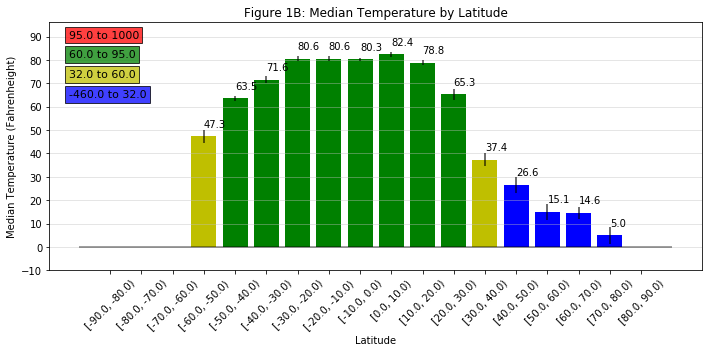

In [19]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [-460.0, 32.0, 60.0, 95.0, 1000]

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon temperature
    c_temp = c_lat_df.loc[ci,'Temp']
    
    # If temperature is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_temp):
        continue
    
    # Set the error bars using the standard deviation of the mean (sem)
    c_sem = c_lat_sem_df.loc[ci,'Temp']
    
    # Select marker color and add it to the list
    c_color = color_list[ np.digitize(c_temp, color_threshold_list) ]

    # Set the placement location for the value text
    c_textloc = c_temp + 4
    
    # Get the value associated with this bar
    c_valuetext = f"{c_temp:.1f}"
        
    # Plot a bar
    plt.bar(ci, c_temp, color=c_color, yerr=c_sem, error_kw={'alpha':0.75})
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='left')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Temp'].min()
y_top = c_lat_df['Temp'].max() + 0.5*c_lat_sem_df['Temp'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Median Temperature (Fahrenheight)")
plt.title("Figure 1B: Median Temperature by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index), alpha='0.5')

plt.tight_layout()
plt.show()

In [20]:
# Save the Figure
fig.savefig("Results/temp_by_latitude_median.png")

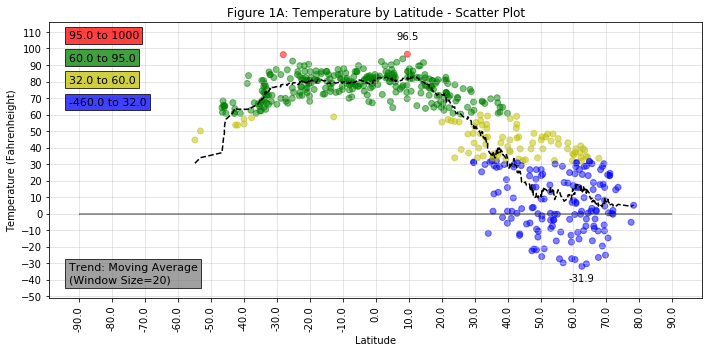

In [21]:
# Generate a scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [-460.0, 32.0, 60.0, 95.0, 1000]

# Initialize array of marker colors
marker_colors = []

# The value to plot
c_plotcolumn = 'Temp'

# Create the markers by iterating through each city
for ci in cities_df.index:
    # Set the color of the markers based upon temperature
    c_plotvalue = cities_df.loc[ci,c_plotcolumn]
        
    # If temperature is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_plotvalue):
        continue
    
    # Select marker color and add it to the list
    marker_colors.append( color_list[ np.digitize(c_plotvalue, color_threshold_list) ] )

# Plot a scatter plot
plt.scatter(cities_df['Actual Lat'], cities_df[c_plotcolumn], c=marker_colors, alpha=0.5)

# Generate a trend line using the moving average
# First, generate a cities dataframe that is sorted by 'Actual Lat'
cities_sorted_df = cities_df.sort_values(by='Actual Lat').reset_index(drop=True)

# Set the window size for the moving average
trend_window_size = 20

# Calculate the moving average
trend = moving_average(cities_sorted_df[c_plotcolumn], trend_window_size)

# Generate the trend plot
plt.plot(cities_sorted_df['Actual Lat'], trend, color='k', linestyle='--')

# Add a value for this point if it is the maximum and minimum points
# Get the index values for value is max and min
# Note: Could end up being multiple data points
ci_max = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].max() ].index
ci_min = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].min() ].index

# Place the values for these points on the scatter plot
plt.text(float(cities_df.loc[ci_max[0],'Actual Lat']),
         float(cities_df.loc[ci_max[0], c_plotcolumn ]) + 9,
         f"{float(cities_df.loc[ci_max[0], c_plotcolumn ]):.1f}" , ha='center')

plt.text(float(cities_df.loc[ci_min[-1],'Actual Lat']),
         float(cities_df.loc[ci_min[-1], c_plotcolumn ]) - 9,
         f"{float(cities_df.loc[ci_min[-1], c_plotcolumn ]):.1f}" , ha='center')

# Set the x tick marks and labels
plt.xticks(cities_df.loc[ci_max,'Actual Lat'], cities_df.loc[ci_max,'Actual Lat'], rotation=45)
x_gran = 10.0
plt.xticks(np.arange(-90.0,90.0+x_gran,x_gran),
           [str(x) for x in np.arange(-90.0,90.0+x_gran,x_gran)],
           rotation=90)

# Set the y access limits to add room for the value labels
y_bot = cities_df[c_plotcolumn].min()
y_top = cities_df[c_plotcolumn].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Temperature (Fahrenheight)")
plt.title("Figure 1A: Temperature by Latitude - Scatter Plot")

plt.grid(True, axis='both', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a key for the moving average
box_text = f"Trend: Moving Average\n(Window Size={trend_window_size})"
box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
plt.text(0.03, 0.05,
         box_text, transform=ax.transAxes,
         fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=box_fmt)

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-90, xmax=+90, alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
# Save the Figure
fig.savefig("Results/temp_by_latitude_scatter.png")

#### Latitude vs. Humidity Plot

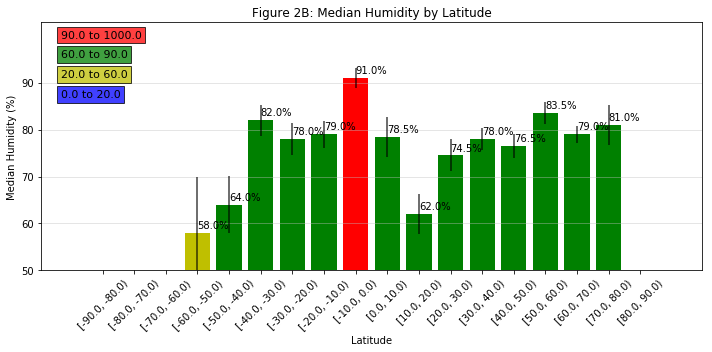

In [23]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 20.0, 60.0, 90.0, 1000.0]

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon humidity
    c_humid = c_lat_df.loc[ci,'Humidity']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_humid):
        continue
       
    # Set the error bars using the standard deviation of the mean (sem)
    c_sem = c_lat_sem_df.loc[ci,'Humidity']
    
    # Select marker color and add it to the list
    c_color = color_list[ np.digitize(c_humid, color_threshold_list) ]

    # Set the placement location for the value text
    c_textloc = c_humid + 1
    
    # Get the value associated with this bar
    c_valuetext = f"{c_humid:.1f}%"
        
    # Plot a bar
    plt.bar(ci, c_humid, color=c_color, yerr=c_sem, error_kw={'alpha':0.75})
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='left')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Humidity'].min()
y_top = c_lat_df['Humidity'].max() + 0.5*c_lat_sem_df['Humidity'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Median Humidity (%)")
plt.title("Figure 2B: Median Humidity by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [24]:
# Save the Figure
fig.savefig("Results/humidity_by_latitude_median.png")

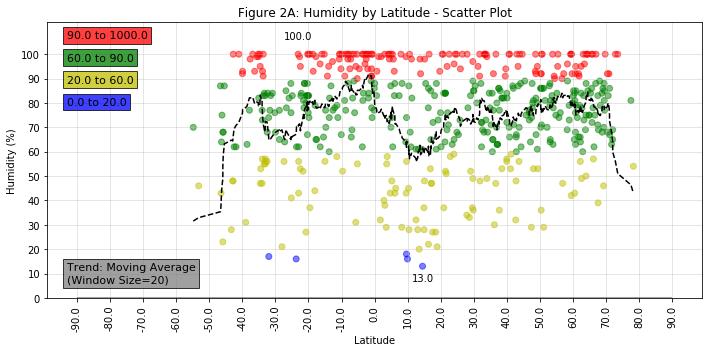

In [25]:
# Generate a scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 20.0, 60.0, 90.0, 1000.0]

# Initialize array of marker colors
marker_colors = []

# The value to plot
c_plotcolumn = 'Humidity'

# Create the markers by iterating through each city
for ci in cities_df.index:
    # Set the color of the markers based upon temperature
    c_plotvalue = cities_df.loc[ci,  c_plotcolumn]
        
    # If temperature is not populated for this bin or is an invalid value,
    #  continue to move to the next bin
    if math.isnan(c_plotvalue) or c_plotvalue < 0.0 or c_plotvalue > 100.0:
        continue
    
    # Select marker color and add it to the list
    marker_colors.append( color_list[ np.digitize(c_plotvalue, color_threshold_list) ] )

# Plot a scatter plot
plt.scatter(cities_df['Actual Lat'], cities_df[c_plotcolumn], c=marker_colors, alpha=0.5)

# Generate a trend line using the moving average
# First, generate a cities dataframe that is sorted by 'Actual Lat'
cities_sorted_df = cities_df.sort_values(by='Actual Lat').reset_index(drop=True)

# Set the window size for the moving average
trend_window_size = 20

# Calculate the moving average
trend = moving_average(cities_sorted_df[c_plotcolumn], trend_window_size)

# Generate the trend plot
plt.plot(cities_sorted_df['Actual Lat'], trend, color='k', linestyle='--')

# Add a value for this point if it is the maximum and minimum points
# Get the index values for value is max and min
# Note: Could end up being multiple data points
ci_max = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].max() ].index
ci_min = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].min() ].index

# Place the values for the first max point and last min point on the scatter plot
plt.text(float(cities_df.loc[ci_max[0],'Actual Lat']),
         float(cities_df.loc[ci_max[0], c_plotcolumn ]) + 6,
         f"{float(cities_df.loc[ci_max[0], c_plotcolumn ]):.1f}" , ha='center')

plt.text(float(cities_df.loc[ci_min[-1],'Actual Lat']),
         float(cities_df.loc[ci_min[-1], c_plotcolumn ]) - 6,
         f"{float(cities_df.loc[ci_min[-1], c_plotcolumn ]):.1f}" , ha='center')

# Set the x tick marks and labels
plt.xticks(cities_df.loc[ci_max,'Actual Lat'], cities_df.loc[ci_max,'Actual Lat'], rotation=45)
x_gran = 10.0
plt.xticks(np.arange(-90.0,90.0+x_gran,x_gran),
           [str(x) for x in np.arange(-90.0,90.0+x_gran,x_gran)],
           rotation=90)

# Set the y access limits to add room for the value labels
y_bot = cities_df[c_plotcolumn].min()
y_top = cities_df[c_plotcolumn].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Figure 2A: Humidity by Latitude - Scatter Plot")

plt.grid(True, axis='both', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a key for the moving average
box_text = f"Trend: Moving Average\n(Window Size={trend_window_size})"
box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
plt.text(0.03, 0.05,
         box_text, transform=ax.transAxes,
         fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=box_fmt)
    
# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-90, xmax=+90, alpha=0.5)

plt.tight_layout()
plt.show()

In [26]:
# Save the Figure
fig.savefig("Results/humidity_by_latitude_scatter.png")

#### Latitude vs. Cloudiness Plot

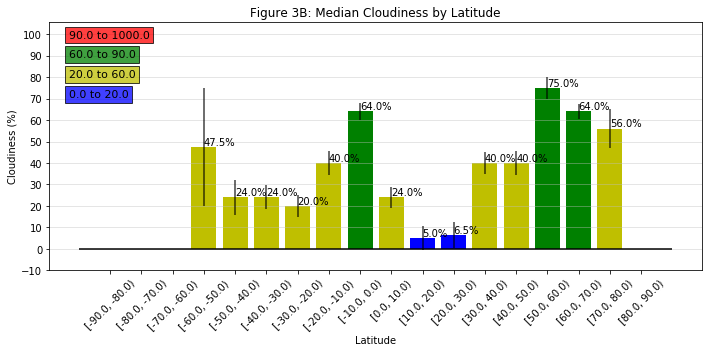

In [27]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 20.0, 60.0, 90.0, 1000.0]

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon cloudiness
    c_cloud = c_lat_df.loc[ci,'Cloudiness']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_cloud):
        continue
    
    # Set the error bars using the standard deviation of the mean (sem)
    c_sem = c_lat_sem_df.loc[ci,'Cloudiness']
    
    # Select marker color and add it to the list
    c_color = color_list[ np.digitize(c_cloud, color_threshold_list) ]

    # Set the placement location for the value text
    c_textloc = c_cloud + 1
    
    # Get the value associated with this bar
    c_valuetext = f"{c_cloud:.1f}%"
        
    # Plot a bar
    plt.bar(ci, c_cloud, color=c_color, yerr=c_sem, error_kw={'alpha':0.75})
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='left')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Cloudiness'].min()
y_top = c_lat_df['Cloudiness'].max() + 0.5*c_lat_sem_df['Cloudiness'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.2
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Figure 3B: Median Cloudiness by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [28]:
# Save the Figure
fig.savefig("Results/cloud_by_latitude_median.png")

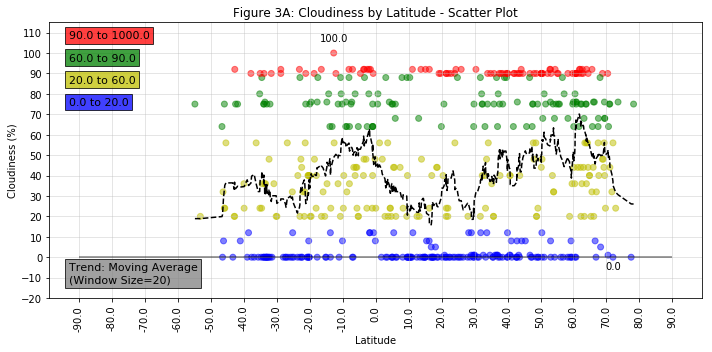

In [29]:
# Generate a scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 20.0, 60.0, 90.0, 1000.0]

# Initialize array of marker colors
marker_colors = []

# The value to plot
c_plotcolumn = 'Cloudiness'

# Create the markers by iterating through each city
for ci in cities_df.index:
    # Set the color of the markers based upon temperature
    c_plotvalue = cities_df.loc[ci,  c_plotcolumn]
        
    # If temperature is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_plotvalue):
        continue
    
    # Select marker color and add it to the list
    marker_colors.append( color_list[ np.digitize(c_plotvalue, color_threshold_list) ] )

# Plot a scatter plot
plt.scatter(cities_df['Actual Lat'], cities_df[c_plotcolumn], c=marker_colors, alpha=0.5)

# Generate a trend line using the moving average
# First, generate a cities dataframe that is sorted by 'Actual Lat'
cities_sorted_df = cities_df.sort_values(by='Actual Lat').reset_index(drop=True)

# Set the window size for the moving average
trend_window_size = 20

# Calculate the moving average
trend = moving_average(cities_sorted_df[c_plotcolumn], trend_window_size)

# Generate the trend plot
plt.plot(cities_sorted_df['Actual Lat'], trend, color='k', linestyle='--')

# Add a value for this point if it is the maximum and minimum points
# Get the index values for value is max and min
# Note: Could end up being multiple data points
ci_max = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].max() ].index
ci_min = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].min() ].index

# Place the values for the first max point and last min point on the scatter plot
plt.text(float(cities_df.loc[ci_max[0],'Actual Lat']),
         float(cities_df.loc[ci_max[0], c_plotcolumn ]) + 6,
         f"{float(cities_df.loc[ci_max[0], c_plotcolumn ]):.1f}" , ha='center')

plt.text(float(cities_df.loc[ci_min[-1],'Actual Lat']),
         float(cities_df.loc[ci_min[-1], c_plotcolumn ]) - 6,
         f"{float(cities_df.loc[ci_min[-1], c_plotcolumn ]):.1f}" , ha='center')

# Set the x tick marks and labels
plt.xticks(cities_df.loc[ci_max,'Actual Lat'], cities_df.loc[ci_max,'Actual Lat'], rotation=45)
x_gran = 10.0
plt.xticks(np.arange(-90.0,90.0+x_gran,x_gran),
           [str(x) for x in np.arange(-90.0,90.0+x_gran,x_gran)],
           rotation=90)

# Set the y access limits to add room for the value labels
y_bot = cities_df[c_plotcolumn].min()
y_top = cities_df[c_plotcolumn].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Figure 3A: Cloudiness by Latitude - Scatter Plot")

plt.grid(True, axis='both', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a key for the moving average
box_text = f"Trend: Moving Average\n(Window Size={trend_window_size})"
box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
plt.text(0.03, 0.05,
         box_text, transform=ax.transAxes,
         fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=box_fmt)
    
# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-90, xmax=+90, alpha=0.5)

plt.tight_layout()
plt.show()

In [30]:
# Save the Figure
fig.savefig("Results/cloud_by_latitude_scatter.png")

#### Latitude vs. Wind Speed Plot

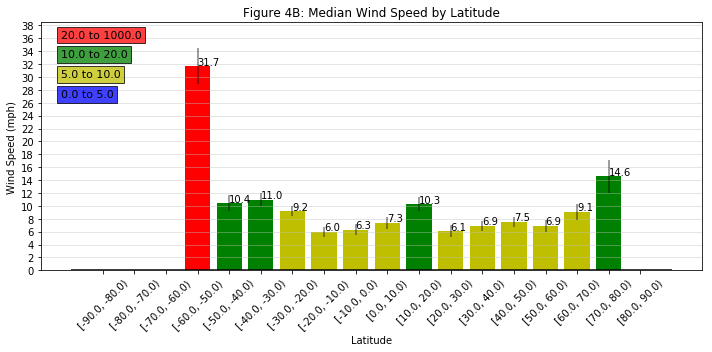

In [31]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 5.0, 10.0, 20.0, 1000.0]

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon wind speed
    c_wind_speed = c_lat_df.loc[ci,'Wind Speed']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_wind_speed):
        continue
    
    # Set the error bars using the standard deviation of the mean (sem)
    c_sem = c_lat_sem_df.loc[ci,'Wind Speed']

    # Select marker color and add it to the list
    c_color = color_list[ np.digitize(c_wind_speed, color_threshold_list) ]

    # Set the placement location for the value text
    c_textloc = c_wind_speed + 0.2
    
    # Get the value associated with this bar
    c_valuetext = f"{c_wind_speed:.1f}"
        
    # Plot a bar
    plt.bar(ci, c_wind_speed, color=c_color, yerr=c_sem, error_kw={'alpha':0.5})
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='left')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Wind Speed'].min()
y_top = c_lat_df['Wind Speed'].max()+ 0.5*c_lat_sem_df['Wind Speed'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.2
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=2))

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Figure 4B: Median Wind Speed by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")


# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [32]:
# Save the Figure
fig.savefig("Results/wind_speed_by_latitude_median.png")

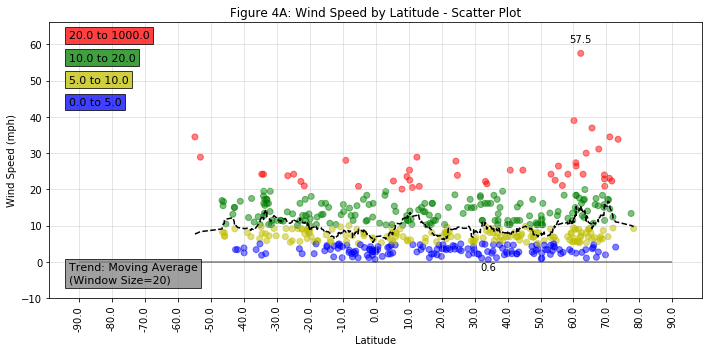

In [33]:
# Generate a scatter plot
fig, ax = plt.subplots(figsize=(10,5))

# Color scheme for markers
color_list = "kbygr"

# Thresholds for selecting colors
color_threshold_list = [0.0, 5.0, 10.0, 20.0, 1000.0]

# Initialize array of marker colors
marker_colors = []

# The value to plot
c_plotcolumn = 'Wind Speed'

# Create the markers by iterating through each city
for ci in cities_df.index:
    # Set the color of the markers based upon temperature
    c_plotvalue = cities_df.loc[ci,  c_plotcolumn]
        
    # If temperature is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_plotvalue):
        continue
    
    # Select marker color and add it to the list
    marker_colors.append( color_list[ np.digitize(c_plotvalue, color_threshold_list) ] )

# Plot a scatter plot
plt.scatter(cities_df['Actual Lat'], cities_df[c_plotcolumn], c=marker_colors, alpha=0.5)

# Generate a trend line using the moving average
# First, generate a cities dataframe that is sorted by 'Actual Lat'
cities_sorted_df = cities_df.sort_values(by='Actual Lat').reset_index(drop=True)

# Set the window size for the moving average
trend_window_size = 20

# Calculate the moving average
trend = moving_average(cities_sorted_df[c_plotcolumn], trend_window_size)

# Generate the trend plot
plt.plot(cities_sorted_df['Actual Lat'], trend, color='k', linestyle='--')

# Add a value for this point if it is the maximum and minimum points
# Get the index values for value is max and min
# Note: Could end up being multiple data points
ci_max = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].max() ].index
ci_min = cities_df.loc[ cities_df[c_plotcolumn] == cities_df[c_plotcolumn].min() ].index

# Place the values for the first max point and last min point on the scatter plot
plt.text(float(cities_df.loc[ci_max[0],'Actual Lat']),
         float(cities_df.loc[ci_max[0], c_plotcolumn ]) + 3,
         f"{float(cities_df.loc[ci_max[0], c_plotcolumn ]):.1f}" , ha='center')

plt.text(float(cities_df.loc[ci_min[-1],'Actual Lat']),
         float(cities_df.loc[ci_min[-1], c_plotcolumn ]) - 3,
         f"{float(cities_df.loc[ci_min[-1], c_plotcolumn ]):.1f}" , ha='center')

# Set the x tick marks and labels
plt.xticks(cities_df.loc[ci_max,'Actual Lat'], cities_df.loc[ci_max,'Actual Lat'], rotation=45)
x_gran = 10.0
plt.xticks(np.arange(-90.0,90.0+x_gran,x_gran),
           [str(x) for x in np.arange(-90.0,90.0+x_gran,x_gran)],
           rotation=90)

# Set the y access limits to add room for the value labels
y_bot = cities_df[c_plotcolumn].min()
y_top = cities_df[c_plotcolumn].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Figure 4A: Wind Speed by Latitude - Scatter Plot")

plt.grid(True, axis='both', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a key for the color coding used on the plot
for i in range(1,len(color_threshold_list)):
    # Text to display
    box_text = f"{color_threshold_list[i-1]} to {color_threshold_list[i]}"
    box_fmt = {'boxstyle':'square', 'facecolor':color_list[i], 'alpha':0.75}
    
    # Plot this
    plt.text(0.03, 0.97 -((len(color_threshold_list)-i-1)*0.08),
             box_text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=box_fmt)

# Add a key for the moving average
box_text = f"Trend: Moving Average\n(Window Size={trend_window_size})"
box_fmt = {'boxstyle':'square', 'facecolor':"gray", 'alpha':0.75}
plt.text(0.03, 0.05,
         box_text, transform=ax.transAxes,
         fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=box_fmt)
    
# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-90, xmax=+90, alpha=0.5)

plt.tight_layout()
plt.show()

In [34]:
# Save the Figure
fig.savefig("Results/wind_speed_by_latitude_scatter.png")